In [65]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
import codecs

In [66]:
class Stats(object):

    def __init__(self):
        self.token_count=0
        self.word_count=0
        self.tree_count=0
        self.words_with_lemma_count=0
        self.words_with_deps_count=0
        self.f_val_counter={} #key:f=val  value: count
        self.deprel_counter={} #key:deprel value: count
        self.sentences = []
        
    def count_cols(self,cols):
        if cols[0].isdigit() or u"." in cols[0]: #word or empty word
            self.word_count+=1
            self.token_count+=1 #every word is also a one-word token
        else: #token
            b,e=cols[0].split(u"-")
            b,e=int(b),int(e)
            self.token_count-=e-b #every word is counted as a token, so subtract all but one to offset for that
        if cols[LEMMA]!=u"_" or (cols[LEMMA]==u"_" and cols[FORM]==u"_"):
            self.words_with_lemma_count+=1
        if cols[CPOSTAG]!=u"_":
            self.f_val_counter[u"CPOSTAG="+cols[CPOSTAG]]=self.f_val_counter.get(u"CPOSTAG="+cols[CPOSTAG],0)+1
        if cols[FEATS]!=u"_":
            for cat_is_vals in cols[FEATS].split(u"|"):
                cat,vals=cat_is_vals.split(u"=",1)
                for val in vals.split(u","):
                    self.f_val_counter[cat+u"="+val]=self.f_val_counter.get(cat+u"="+val,0)+1
        if cols[DEPREL]!=u"_":
            self.deprel_counter[cols[DEPREL]]=self.deprel_counter.get(cols[DEPREL],0)+1
        if cols[DEPS]!=u"_":
            self.words_with_deps_count+=1
            for head_and_deprel in cols[DEPS].split(u"|"):
                head,deprel=head_and_deprel.split(u":",1)
                self.deprel_counter[deprel]=self.deprel_counter.get(deprel,0)+1
    
    def print_pos_tag(self):
        pos_tag = {}
        for cat_is_val in self.f_val_counter:
            if cat_is_val.startswith(u"CPOSTAG="):
                print(cat_is_val, self.f_val_counter.get(cat_is_val))
                pos_tag[cat_is_val] = self.f_val_counter.get(cat_is_val)
        x = np.arange(len(pos_tag))
        items = list(pos_tag.items())
        plt.bar(x, height=[item[1] for item in items] )
        plt.xticks(x, list(map(lambda x: x[8:], [item[0] for item in items])))
        plt.show()
        
        summ = sum([item[1] for item in items])
        plt.bar(x, height = [(y[1] / summ) for y in items])
        plt.xticks(x, list(map(lambda x: x[8:], [item[0] for item in items])))
        plt.show()
        
        
    
    def trees(self, inp):
        """
        `inp` a file-like object yielding lines as unicode

        Yields the input a tree at a time.
        """
        comments=[] #List of comment lines to go with the current tree
        lines=[] #List of token/word lines of the current tree
        for line_counter, line in enumerate(inp):
            line=line.rstrip()
            if not line: #empty line
                if lines: #Sentence done, yield. Skip otherwise.
                    yield comments, lines
                    comments=[]
                    lines=[]
            elif line[0]==u"#":
                comments.append(line)
            elif line[0].isdigit():
                cols=line.split(u"\t")
                #print(cols[ID]+' ')
                if len(cols)!=COLCOUNT:
                    print >> sys.stderr, u"Line %d: The line has %d columns, but %d are expected. Giving up."%(line_counter+1,len(cols),COLCOUNT)
                    sys.exit(1)
                lines.append(cols)
            else: #A line which is not a comment, nor a token/word, nor empty. That's bad!
                #TODO warn!
                print >> sys.stderr, u"Line %d not conllu: Giving up."%(line_counter+1)
                sys.exit(1) #Give a non-zero exit code
        else: #end of file
            if comments or lines: #Looks like a forgotten empty line at the end of the file, well, okay...
                yield comments, lines

In [67]:
COLCOUNT=10
ID,FORM,LEMMA,CPOSTAG,POSTAG,FEATS,HEAD,DEPREL,DEPS,MISC=range(COLCOUNT)
COLNAMES=u"ID,FORM,LEMMA,CPOSTAG,POSTAG,FEATS,HEAD,DEPREL,DEPS,MISC".split(u",")

In [68]:
inp_raw=open('ru_syntagrus-ud-train.conllu',mode="rb")
inp=codecs.getreader("utf-8")(inp_raw)

inp_raw2=open('ru_syntagrus-ud-test.conllu',mode="rb")
inp2=codecs.getreader("utf-8")(inp_raw2)

In [69]:
def word2features(doc, i):
    word = doc[i][FORM]

    # Common features for all words
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit()
    ]

    # Features for words that are not
    # at the beginning of a document
    if i > 0:
        word1 = doc[i-1][0]
        postag1 = doc[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:word.isdigit=%s' % word1.isdigit()
        ])
    else:
        # Indicate that it is the 'beginning of a document'
        features.append('BOS')

    # Features for words that are not
    # at the end of a document
    if i < len(doc)-1:
        word1 = doc[i+1][0]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:word.isdigit=%s' % word1.isdigit()
        ])
    else:
        # Indicate that it is the 'end of a document'
        features.append('EOS')

    return features

from sklearn.model_selection import train_test_split

# A function for extracting features in documents
def extract_features(doc):
    return [word2features(doc, i) for i in range(len(doc))]

In [70]:
import pycrfsuite
from pycrfsuite import ItemSequence
from sklearn.model_selection import train_test_split

stats=Stats()

trees = stats.trees(inp)
#f = open("demofile.txt", "w")
train = []
labels = []
try:
    trees = list(trees)
    for comments,tree in trees:
        stats.tree_count+=1
        for cols in tree:
            stats.count_cols(cols)
            #if cols[ID] == "1":
            #    f.write('\n')
            #f.write(cols[FORM]+'_'+cols[CPOSTAG]+' ')
        train.append(extract_features(tree))
        labels.append([cols[CPOSTAG] for cols in tree])
    #f.close()
except:
    traceback.print_exc()
    print >> sys.stderr, "\n\n ------- STATS MAY BE EMPTY OR INCOMPLETE ----------"
    pass


stats=Stats()

trees = stats.trees(inp2)
test = []
testlabels = []
try:
    trees = list(trees)
    for comments,tree in trees:
        stats.tree_count+=1
        for cols in tree:
            stats.count_cols(cols)
        test.append(extract_features(tree))
        testlabels.append([cols[CPOSTAG] for cols in tree])
except:
    traceback.print_exc()
    print >> sys.stderr, "\n\n ------- STATS MAY BE EMPTY OR INCOMPLETE ----------"
    pass

In [71]:
X_train, y_train = train, labels
import pycrfsuite
trainer = pycrfsuite.Trainer(verbose=True)

# Submit training data to the trainer
for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

# Set the parameters of the model
trainer.set_params({
    # coefficient for L1 penalty
    'c1': 0.1,

    # coefficient for L2 penalty
    'c2': 0.01,  

    # maximum number of iterations
    'max_iterations': 200,

    # whether to include transitions that
    # are possible, but not observed
    'feature.possible_transitions': True
})

# Provide a file name as a parameter to the train function, such that
# the model will be saved to the file when training is finished
trainer.train('crf.model')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 119907
Seconds required: 2.642

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 2049887.947088
Feature norm: 1.000000
Error norm: 355746.899438
Active features: 119771
Line search trials: 1
Line search step: 0.000001
Seconds required for this iteration: 3.473

***** Iteration #2 *****
Loss: 1938710.177465
Feature norm: 1.374756
Error norm: 250161.846795
Active features: 119082
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 1.736

***** Iteration #3 *****
Loss: 1848583.221162
Feature norm: 1.903415
Error norm: 234106.358259
Active features: 119359
Line search trials: 1
Line search step: 1.000000
Seconds

***** Iteration #39 *****
Loss: 74594.600103
Feature norm: 430.509872
Error norm: 1824.386512
Active features: 77201
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 1.809

***** Iteration #40 *****
Loss: 71330.592982
Feature norm: 452.587639
Error norm: 1532.168711
Active features: 76149
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 1.975

***** Iteration #41 *****
Loss: 71029.377180
Feature norm: 455.945959
Error norm: 9456.714393
Active features: 75786
Line search trials: 4
Line search step: 0.125000
Seconds required for this iteration: 7.207

***** Iteration #42 *****
Loss: 67905.276073
Feature norm: 468.582855
Error norm: 1677.792191
Active features: 75250
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 1.719

***** Iteration #43 *****
Loss: 65681.930695
Feature norm: 481.751752
Error norm: 3486.274012
Active features: 73647
Line search trials: 1
Line search step: 1.0

In [73]:
tagger = pycrfsuite.Tagger()
tagger.open('crf.model')
y_pred = [tagger.tag(xseq) for xseq in test]
import numpy as np
from sklearn.metrics import classification_report

labels = {"CCONJ": 0, "X":1, "PUNCT":2, "INTJ":3, "AUX":4, "DET":5, "ADJ":6, "ADP":7, "NUM":8, 
          "PROPN":9, "SYM":10, "PART":11, "NOUN":12, "VERB":13, "PRON":14, "SCONJ":15, "ADV":16, "_":17}


# Convert the sequences of tags into a 1-dimensional array
predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in testlabels for tag in row])

# Print out the classification report
print(classification_report(
    truths, predictions))


             precision    recall  f1-score   support

          0       0.95      0.98      0.96      4156
          1       0.78      0.45      0.57        31
          2       1.00      1.00      1.00     21386
          3       1.00      0.27      0.43        11
          4       0.91      0.95      0.93       889
          5       0.92      0.93      0.92      2755
          6       0.93      0.96      0.95     10989
          7       1.00      1.00      1.00     11516
          8       0.98      0.98      0.98      2691
          9       0.96      0.95      0.96      4754
         10       1.00      1.00      1.00       144
         11       0.95      0.92      0.93      3475
         12       0.99      0.98      0.98     28651
         13       0.97      0.95      0.96     12964
         14       0.95      0.93      0.94      5022
         15       0.87      0.94      0.91      2048
         16       0.95      0.95      0.95      5847
         17       1.00      1.00      1.00   

CPOSTAG=CCONJ 30432
CPOSTAG=X 375
CPOSTAG=PUNCT 157984
CPOSTAG=INTJ 78
CPOSTAG=AUX 6315
CPOSTAG=DET 21968
CPOSTAG=ADJ 85589
CPOSTAG=ADP 81963
CPOSTAG=NUM 13746
CPOSTAG=PROPN 32401
CPOSTAG=SYM 840
CPOSTAG=PART 27858
CPOSTAG=NOUN 214497
CPOSTAG=VERB 97670
CPOSTAG=PRON 38438
CPOSTAG=SCONJ 16219
CPOSTAG=ADV 44101


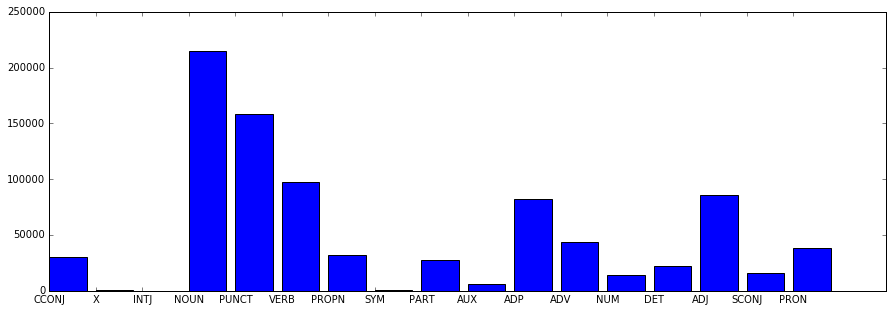

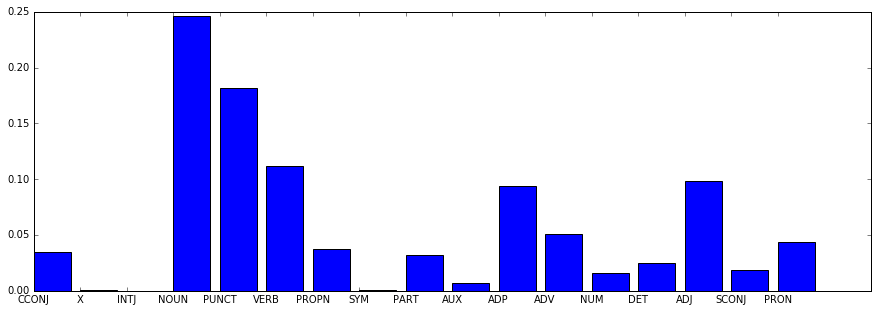

In [15]:
stats.print_pos_tag()